In [1]:
import os
from string import Template
from collections import namedtuple

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '..')
from src.data import TimeSeries
from src.methods.spc import FControlChart, PatternFunction
from src.eval import (
    mean_time_from_event,
    classification_metrics
)

In [2]:
br_train = TimeSeries.from_csv(
    'pandas',
    '../data/blood-refrigerator/train.csv'
)
br_dev = TimeSeries.from_csv(
    'pandas',
    '../data/blood-refrigerator/val.csv'
)
br_test = TimeSeries.from_csv(
    'pandas',
    '../data/blood-refrigerator/test.csv'
)
print(br_train.shape, br_dev.shape, br_test.shape)
br_dev.head()

(60166, 14) (13992, 14) (65763, 14)


,timestamp,Product temperature base [°C],Evaportator temperature base [°C],Power supply [V],Condenser temperature base [°C],Instant power consumption [W],Signal [DBM],Door_alert,Door_close,Door_open,Machine_cooling,Machine_defrost,Machine_pause,PW_0.5h
0,2022-11-24 17:38:58.399500,0.677748,0.354826,-0.321659,-0.785476,-0.685568,-1.45181,0.0,1.0,0.0,1.0,0.0,0.0,0
1,2022-11-24 17:39:32.544000,0.677748,0.354826,-0.321659,-0.785476,-0.685568,-1.45181,0.0,1.0,0.0,1.0,0.0,0.0,0
2,2022-11-24 17:40:06.688500,0.677748,-0.629940,0.214894,0.093322,-0.685568,-1.45181,0.0,1.0,0.0,0.0,0.0,1.0,0
3,2022-11-24 17:40:40.833000,0.677748,-0.629940,0.214894,0.093322,-0.685568,-1.45181,0.0,1.0,0.0,0.0,0.0,1.0,0
4,2022-11-24 17:41:14.977500,0.677748,-0.629940,0.214894,0.093322,-0.685568,-1.45181,0.0,1.0,0.0,0.0,0.0,1.0,0


In [3]:
br_train.parse_datetime('timestamp')
br_dev.parse_datetime('timestamp')
br_test.parse_datetime('timestamp')

br_train.split_by_day()
br_dev.split_by_day()
br_test.split_by_day()

len(br_train.time_series), len(br_dev.time_series), len(br_test.time_series)

(25, 7, 27)

In [4]:
splits = [0.25, 0.5, 0.75, 1.0]
br_train_splits = {}

for pct in splits:
    n_days = len(br_train.time_series)
    train_days = list(br_train.time_series.keys())[-int(pct*n_days):]
    y = pd.concat([
        br_train.time_series[k]['PW_0.5h'] for k in train_days
    ])
    X = pd.concat([
        br_train.time_series[k].drop(
            columns=['timestamp','PW_0.5h','date','time']
        ) for k in train_days
    ])

    # Drop std=0 variables
    X = X[
        [c for c in X.columns if np.std(X[c]) != 0]
    ]

    if pct == 0.25:
        keep_cols = X.columns
        
    br_train_splits.update(
        {
            str(pct):
            {
                'X': X.values,
                'y': y.values,
                'cols': keep_cols.tolist()
            }
        }
    )
    print(f"{pct}\t-\t{X.shape}\t-\t{y.shape}\t-\n{keep_cols.tolist()}\n")

0.25	-	(14512, 12)	-	(14512,)	-
['Product temperature base [°C]', 'Evaportator temperature base [°C]', 'Power supply [V]', 'Condenser temperature base [°C]', 'Instant power consumption [W]', 'Signal [DBM]', 'Door_alert', 'Door_close', 'Door_open', 'Machine_cooling', 'Machine_defrost', 'Machine_pause']

0.5	-	(29695, 12)	-	(29695,)	-
['Product temperature base [°C]', 'Evaportator temperature base [°C]', 'Power supply [V]', 'Condenser temperature base [°C]', 'Instant power consumption [W]', 'Signal [DBM]', 'Door_alert', 'Door_close', 'Door_open', 'Machine_cooling', 'Machine_defrost', 'Machine_pause']

0.75	-	(44878, 12)	-	(44878,)	-
['Product temperature base [°C]', 'Evaportator temperature base [°C]', 'Power supply [V]', 'Condenser temperature base [°C]', 'Instant power consumption [W]', 'Signal [DBM]', 'Door_alert', 'Door_close', 'Door_open', 'Machine_cooling', 'Machine_defrost', 'Machine_pause']

1.0	-	(60166, 12)	-	(60166,)	-
['Product temperature base [°C]', 'Evaportator temperature

In [5]:
br_dev_data = {
    'X': {dt: x[keep_cols].values for dt, x in br_dev.time_series.items()},
    'y': {dt: x['PW_0.5h'].values for dt, x in br_dev.time_series.items()}
}
br_test_data = {
    'X': {dt: x[keep_cols].values for dt, x in br_test.time_series.items()},
    'y': {dt: x['PW_0.5h'].values for dt, x in br_test.time_series.items()}
}

In [6]:
charts = {}

for nm, split in br_train_splits.items():
    print(nm)
    br_chart = FControlChart()
    br_chart.determine_parameters(split['X'])
    charts.update(
        {
            nm: br_chart
        }
    )
    print(br_chart.lcl, br_chart.center_line, br_chart.ucl)

0.25
4.404941682435892 11.34058021485056 23.32754805580418
0.5
4.404351913862328 11.340448361372397 23.33220932530158
0.75
4.404161271096155 11.340405734198246 23.333716519718745
1.0
4.404066540800883 11.340384551773846 23.334465523566962


In [7]:
def exceeds_n_breaches(values: np.ndarray, ucl, n):
    if (values > ucl).sum() >= 5:
        return True
    return False

def n_sequential_breaches(values: np.ndarray, ucl, n):
    if (values > ucl).sum() == n:
        return True
    return False 

dev_matches = {}
test_matches = {}

for nm, chart in charts.items():
    print(nm)
    dev_matches[nm] = {}
    test_matches[nm] = {}
    
    for n in [5,10,20,40,80]:
        chart.add_patterns(
            {
                f'{n}per{n*2}at0.05': PatternFunction(
                    exceeds_n_breaches,
                    int(n*2),
                    {'ucl': chart.ucl, 'n':n}
                ),
                f'{n}seqAt0.05': PatternFunction(
                    exceeds_n_breaches,
                    int(n),
                    {'ucl': chart.ucl, 'n':n}
                )
            }
        )
    
    for dt, X in br_dev_data['X'].items():
        matched = chart.check_patterns(X)
        for pattern, res in matched.items():
            if not dev_matches[nm].get(pattern, False):
                dev_matches[nm].update({pattern: {}})
            dev_matches[nm][pattern].update(
                {
                    dt: res
                }
            )
        
    for dt, X in br_test_data['X'].items():
        matched = chart.check_patterns(X)
        for pattern, res in matched.items():
            if not test_matches[nm].get(pattern, False):
                test_matches[nm].update({pattern: {}})
            test_matches[nm][pattern].update(
                {
                    dt: res
                }
            )
    
    print(len(dev_matches), len(test_matches))

0.25
1 1
0.5
2 2
0.75
3 3
1.0
4 4


In [8]:
res_out = Template(
    "Pattern: $pattern\n"
    "\tMTFE:\t$mtfe\n"
    "\tF1:\t$f1\n"
    "\tRecall:\t$recall\n"
    "\tPrecision:\t$precision\n"
)

ResultTup = namedtuple(
    'ResultTup',
    ['split_pct','pattern','strict','mean_time_from_event','f1','precision','recall']
)

In [9]:
dev_result_for_out = []

print('=== Not Strict ===')
for pct, res in dev_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(br_dev_data['y'], matches)
        hits, mets = classification_metrics(br_dev_data['y'], matches)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
        dev_result_for_out.append(
            ResultTup(
                pct,
                pattern,
                0,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )

print('\n=== Strict ===')
for pct, res in dev_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(br_dev_data['y'], matches, strict=True)
        hits, mets = classification_metrics(br_dev_data['y'], matches, strict=True)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
        dev_result_for_out.append(
            ResultTup(
                pct,
                pattern,
                1,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )
        
dev_result_df = pd.DataFrame(dev_result_for_out)
dev_result_df

=== Not Strict ===

=== Strict ===


,split_pct,pattern,strict,mean_time_from_event,f1,precision,recall
0,0.25,5per10at0.05,0,-135.000000,0.75,1.0,0.6
1,0.25,5seqAt0.05,0,-133.571429,0.75,1.0,0.6
2,0.25,10per20at0.05,0,-140.142857,0.00,0.0,0.0
3,0.25,10seqAt0.05,0,-135.000000,0.75,1.0,0.6
4,0.25,20per40at0.05,0,-151.571429,0.00,0.0,0.0
...,...,...,...,...,...,...,...
75,1.0,20seqAt0.05,1,-103.714286,0.00,0.0,0.0
76,1.0,40per80at0.05,1,-148.142857,0.00,0.0,0.0
77,1.0,40seqAt0.05,1,-119.285714,0.00,0.0,0.0
78,1.0,80per160at0.05,1,-205.714286,0.00,0.0,0.0


<Axes: >

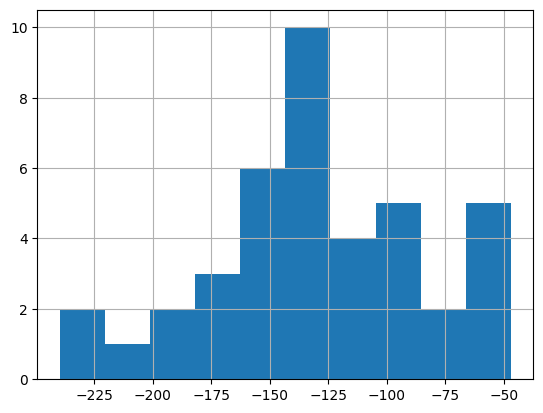

In [10]:
dev_result_df[dev_result_df['strict']==0]['mean_time_from_event'].hist()

<Axes: >

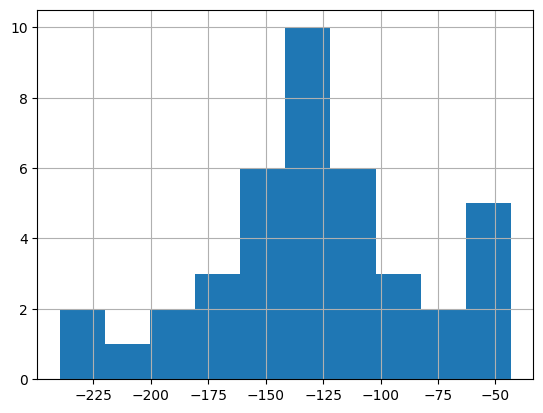

In [11]:
dev_result_df[dev_result_df['strict']==1]['mean_time_from_event'].hist()

In [12]:
test_result_for_out = []

print('=== Not Strict ===')
for pct, res in test_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(br_test_data['y'], matches)
        hits, mets = classification_metrics(br_test_data['y'], matches)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
        test_result_for_out.append(
            ResultTup(
                pct,
                pattern,
                0,
                mtfe,
                mets['f1'],
                mets['precision'],
                mets['recall']
            )
        )

print('\n=== Strict ===')
for pct, res in test_matches.items():
    for pattern, matches in res.items():  
        diffs, mtfe = mean_time_from_event(br_test_data['y'], matches, strict=True)
        hits, mets = classification_metrics(br_test_data['y'], matches, strict=True)
#         print(
#             res_out.substitute(
#                 pattern=pattern,
#                 mtfe=mtfe,
#                 **mets
#             )
#         )
#         test_result_for_out.append(
        ResultTup(
            pct,
            pattern,
            1,
            mtfe,
            mets['f1'],
            mets['precision'],
            mets['recall']
        )
    
test_result_df = pd.DataFrame(test_result_for_out)
test_result_df

=== Not Strict ===

=== Strict ===


,split_pct,pattern,strict,mean_time_from_event,f1,precision,recall
0,0.25,5per10at0.05,0,-166.000000,0.400000,1.0,0.250000
1,0.25,5seqAt0.05,0,-163.962963,0.400000,1.0,0.250000
2,0.25,10per20at0.05,0,-170.777778,0.285714,1.0,0.166667
3,0.25,10seqAt0.05,0,-166.000000,0.400000,1.0,0.250000
4,0.25,20per40at0.05,0,-180.148148,0.285714,1.0,0.166667
5,0.25,20seqAt0.05,0,-170.777778,0.285714,1.0,0.166667
6,0.25,40per80at0.05,0,-197.925926,0.285714,1.0,0.166667
7,0.25,40seqAt0.05,0,-180.148148,0.285714,1.0,0.166667
8,0.25,80per160at0.05,0,-233.481481,0.285714,1.0,0.166667
9,0.25,80seqAt0.05,0,-197.925926,0.285714,1.0,0.166667


<Axes: >

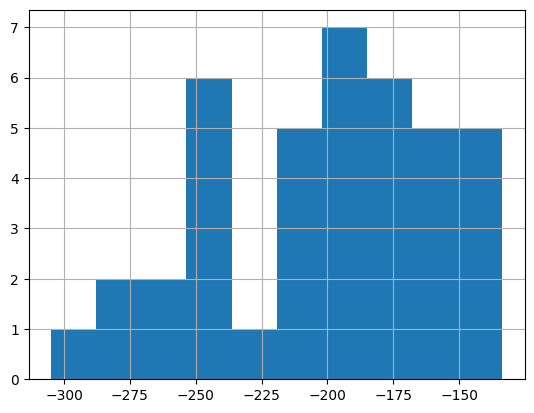

In [13]:
test_result_df[test_result_df['strict']==0]['mean_time_from_event'].hist()

<Axes: >

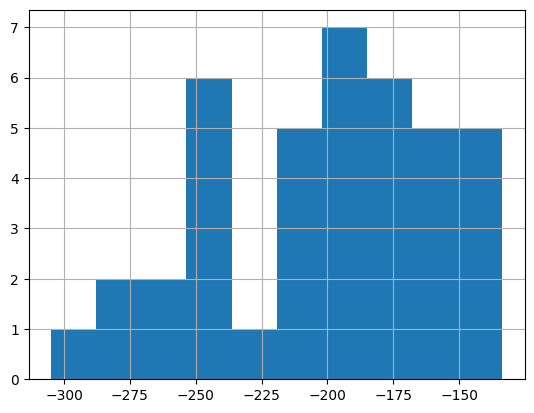

In [14]:
test_result_df[test_result_df['strict']==0]['mean_time_from_event'].hist()

In [40]:
dev_result_df.to_csv(
    '../results/fcontrolchart_dev_results.csv',
    sep='\t',
    header=True,
    index=False
)
test_result_df.to_csv(
    '../results/fcontrolchart_test_results.csv',
    sep='\t',
    header=True,
    index=False
)